In [1]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings("error")

Define the function to get the paths from past points:

In [2]:
def calculatePaths (xPoints, yPoints):
    xArray = np.array([])

    for x in xPoints:
        xArray = np.append(xArray, x)

    polynomial = PolynomialFeatures(degree=3, include_bias=False)
    polynomial_features = polynomial.fit_transform(xArray.reshape(-1, 1))
    polynomial_regression_model = linear_model.LinearRegression()

    model = polynomial_regression_model.fit(polynomial_features, yPoints)

    return model.coef_, model.intercept_

Define the function to calculate paths have a common point:

In [3]:
def findIntercept (lowerRange, upperRange, coeffRobot, interRobot, coeffPerson, interPerson): #f,
    def f(xy):
        x, y = xy
        z = np.array([y-coeffRobot[2]*x**3-coeffRobot[1]*x**2-coeffRobot[0]*x-interRobot, y-coeffPerson[2]*x**3-coeffPerson[1]*x**2-coeffPerson[0]*x-interPerson])
        return z
    return (fsolve(f, [lowerRange, upperRange]))

Define the function to calculate moving agent's distance to the collision point:

In [4]:
def calculate_Distance_to_Collision(coef_array, intercept, origin_point_x,origin_point_y, collision_point_x, collision_point_y): #input current positions and predictions, output time and or distance until collision
       
    if origin_point_x <  collision_point_x:
        larger=collision_point_x
        smaller=origin_point_x
        y_coordinate_previous=origin_point_y
        x_coordinate_previous=origin_point_x
        
    else:
        larger=origin_point_x
        smaller=collision_point_x
        y_coordinate_previous=collision_point_y
        x_coordinate_previous=collision_point_x
        
    step=float(larger-smaller)/200
    x=0
    y_coordinate=0
    x_coordinate=0
    distance_y=0
    distance_x=0
    total_distance=0
    while((smaller+x*step)<=larger):
        y_coordinate=coef_array[2]*(smaller+x*step)**3+coef_array[1]*(smaller+x*step)**2+coef_array[0]*(smaller+x*step)+intercept
        distance_y=y_coordinate-y_coordinate_previous 
        y_coordinate_previous=y_coordinate
        x_coordinate=smaller+x*step
        distance_x=x_coordinate-x_coordinate_previous
        x_coordinate_previous=x_coordinate
        total_distance=total_distance + np.sqrt((distance_y**2)+(distance_x**2))
        x=x+1
    return total_distance


Define the function to calculate the speed of the moving agents:

In [5]:
def calculateCurrentSpeed (Xpositionlist = [], Ypositionlist=[], *args):

    total_Xdistance_in_1_sec= Xpositionlist[-1]-Xpositionlist[-4] # Only a subtraction among the two points is done assuming linearity.
    total_Ydistance_in_1_sec= Ypositionlist[-1]-Ypositionlist[-4] # Since its 1 second it should not be a problem.

    current_Xspeed = total_Xdistance_in_1_sec  # V=distance/time [m/s]; time is 1s 
    current_Yspeed = total_Ydistance_in_1_sec

    current_speed = np.sqrt(((current_Xspeed**2)+(current_Yspeed**2)))
    return current_speed

Define the function to calculate the time until the collision:

In [6]:
def calculateTimeToCollision(distanceToCollision, speed): #input current positions and predictions, output time and or distance until collision
    time_to_collision=distanceToCollision/speed
    return time_to_collision

Define the function to check if the possible collision must be taken into account:

In [7]:
def takeCrossingIntoAccount (interception, xRobot, yRobot, xPerson, yPerson):
    if (xRobot[0]<xRobot[-1]):
        xRobotSmall = xRobot[0]
        xRobotBig = xRobot[-1]
    else:
        xRobotSmall = xRobot[-1]
        xRobotBig = xRobot[0]
        
    if (xPerson [0] < xPerson[-1]):
        xPersonSmall = xPerson[0]
        xPersonBig = xPerson[-1]
    else:
        xPersonSmall = xPerson[-1]
        xPersonBig = xPerson[0]
    
    if ((((xRobot[0]-interception[0])**2+(yRobot[0]-interception[1])**2) < ((xRobot[-1]-interception[0])**2+(yRobot[-1]-interception[1])**2)) or (((xPerson[0]-interception[0])**2+(yPerson[0]-interception[1])**2) < ((xPerson[-1]-interception[0])**2+(yPerson[-1]-interception[1])**2)) or (xRobotSmall < interception[0] < xRobotBig) or (xPersonSmall < interception[0] < xPersonBig)): #If collision point was closer in t-4 than in the latest position, the robot is going away from the collision point->No need to take it into account
        return False
    else: #collision must be taken into account
        return True 

Define the function to check if collision time are similar enough to represent a dangerous situation:

In [8]:
def areCollisionTimesClose (robotTimeToCollide, personTimeToCollide, delta):
    if (((robotTimeToCollide+delta) >= personTimeToCollide) and ((robotTimeToCollide-delta) <= personTimeToCollide)):
        return True
    else:
        return False

# Test 1:

Define paths to try the functions out:

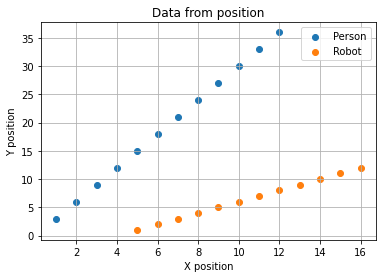

In [9]:
xPerson = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
yPerson = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
xRobot = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
yRobot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

Notice how there is an interception from the mathematical POV but in reality the moving agents are getting further. We should predict that no collision is going to happen.

In [10]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agents are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to collision: " + str(robotTimeCollision) + "Person time to collision: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

No collision danger. Moving agents are moving away from intercept.


# Test 2:

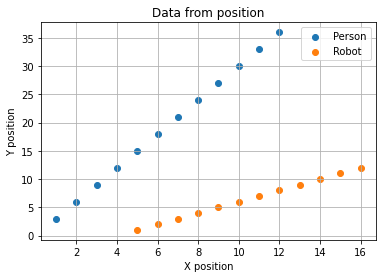

In [11]:
xPerson = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
yPerson = [36, 33, 30, 27, 24, 21, 18, 15, 12, 9, 6, 3]
xRobot = [16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5]
yRobot = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

The plot is identical to the one in "case 1", but in this case the moving agents are getting closer to the intercept.

In [12]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agents are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")
    

The collision must be taken into account. Robot time to intercept: 2.3333333333333193. Person time to intercept: 0.9999999999999926


# Test 3:

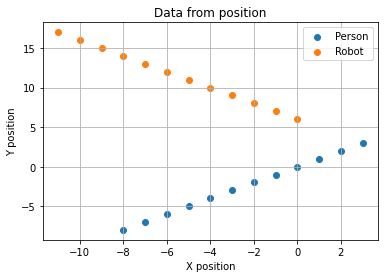

In [13]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
yRobot = [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [14]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agents are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")
    

The collision must be taken into account. Robot time to intercept: 1.0000000000000036. Person time to intercept: 2.8918399387615934e-15


# Test 4:

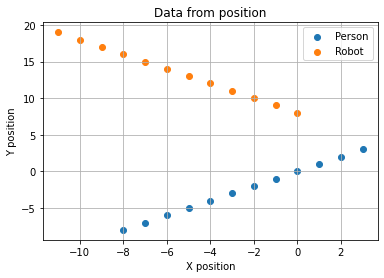

In [15]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
yRobot = [19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8]
yRobot2 = [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [16]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agents are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

The collision must be taken into account. Robot time to intercept: 1.333333333333336. Person time to intercept: 0.3333333333333359


# Test 5:

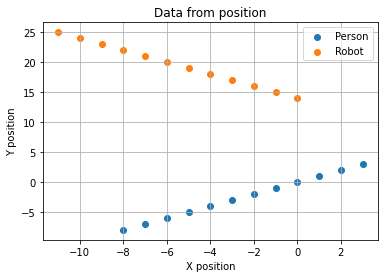

In [17]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
yRobot = [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14]
yRobot2 = [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [18]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

The collision must be taken into account. Robot time to intercept: 2.321666666666668. Person time to intercept: 1.3333333333333395


# Test 6:

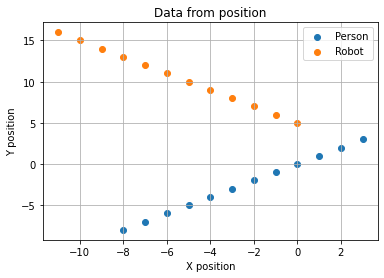

In [19]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
yRobot = [16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5]
yRobot2 = [17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]

plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [20]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

No collision danger. Moving agent(s) are moving away from intercept.


# Test 7:

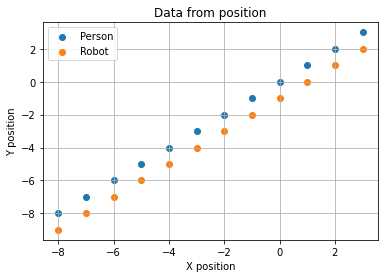

In [21]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yRobot = [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2]



plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [22]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

No collision danger. There is no intercept.


# Test 8:

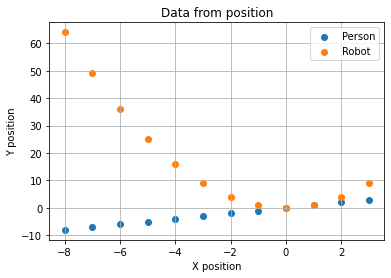

In [23]:
xPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yPerson = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
xRobot = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
yRobot = [64, 49, 36, 25, 16, 9, 4, 1, 0, 1, 4, 9]



plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [24]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

No collision danger. Moving agent(s) are moving away from intercept.


# Test 9:

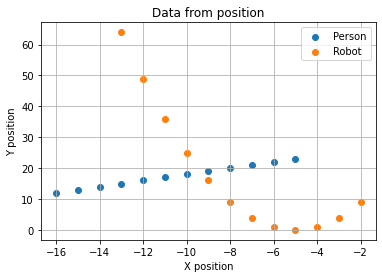

In [25]:
xPerson = [-8-8, -7-8, -6-8, -5-8, -4-8, -3-8, -2-8, -1-8, 0-8, 1-8, 2-8, 3-8]
yPerson = [-8+20, -7+20, -6+20, -5+20, -4+20, -3+20, -2+20, -1+20, 0+20, 1+20, 2+20, 3+20]
xRobot = [-13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]
yRobot = [64, 49, 36, 25, 16, 9, 4, 1, 0, 1, 4, 9]



plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [26]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

The collision must be taken into account. Robot time to intercept: 2.0386746568621663. Person time to intercept: 1.7739417934989654


In [27]:
intercept

array([ 0.32182538, 28.32182538])

# Test 10

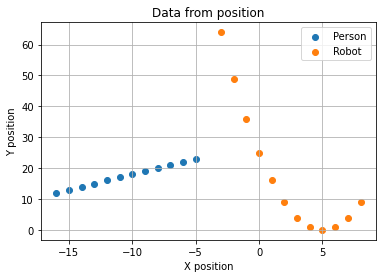

In [28]:
xPerson = [-8-8, -7-8, -6-8, -5-8, -4-8, -3-8, -2-8, -1-8, 0-8, 1-8, 2-8, 3-8]
yPerson = [-8+20, -7+20, -6+20, -5+20, -4+20, -3+20, -2+20, -1+20, 0+20, 1+20, 2+20, 3+20]
xRobot = [-13+10, -12+10, -11+10, -10+10, -9+10, -8+10, -7+10, -6+10, -5+10, -4+10, -3+10, -2+10]
yRobot = [64, 49, 36, 25, 16, 9, 4, 1, 0, 1, 4, 9]



plt.figure()
plt.grid("True")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Data from position")
plt.scatter(xPerson, yPerson, label="Person")
plt.scatter(xRobot, yRobot, label="Robot")
plt.legend()
plt.show()

In [29]:
robotCoefs, robotIntercept = calculatePaths (xRobot, yRobot)
personCoefs, personIntercept = calculatePaths (xPerson, yPerson)

try:
    intercept = findIntercept (0, 50, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1

if (type(intercept) == int):
    print("No collision danger. There is no intercept.")
else:    
    if (not takeCrossingIntoAccount (intercept, xRobot, yRobot, xPerson, yPerson)):
        print("No collision danger. Moving agent(s) are moving away from intercept.")
    else:
        robotDistanceCollision = calculate_Distance_to_Collision(robotCoefs, robotIntercept, xRobot[-1], yRobot[-1], intercept[0], intercept[1])
        personDistanceCollision = calculate_Distance_to_Collision(personCoefs, personIntercept, xPerson[-1], yPerson[-1], intercept[0], intercept[1])
        
        robotSpeed = calculateCurrentSpeed (xRobot, yRobot)
        personSpeed = calculateCurrentSpeed (xPerson, yPerson)
        
        robotTimeCollision = calculateTimeToCollision (robotDistanceCollision, robotSpeed)
        personTimeCollision = calculateTimeToCollision (personDistanceCollision, personSpeed)
        
        if(areCollisionTimesClose(robotTimeCollision, personTimeCollision, 5)):
            print("The collision must be taken into account. Robot time to intercept: " + str(robotTimeCollision) + ". Person time to intercept: " + str(personTimeCollision))
        else:
            print("Time difference is greater than defined delta. It is considered that there is no danger.")

No collision danger. Moving agent(s) are moving away from intercept.


In [30]:
intercept

array([-0.2662813, 27.7337187])

In [6]:
robotCoefs, robotIntercept = [0.43691715, -1.3165747, 2.08177264], 12.46355
personCoefs, personIntercept = [5788.533, -39756.0935, 89936.739], -263.147

try:
    intercept = findIntercept (0, 0, robotCoefs, robotIntercept, personCoefs, personIntercept)
    
except RuntimeWarning:
    intercept = -1
print(intercept)

[ 0.11083725 12.4986373 ]
